Data Preprocesing

In [17]:
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import librosa
audio_file_path="/content/drive/MyDrive/GlobalAIHub/test1.wav"
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [20]:
print(librosa_audio_data)

[-0.00269916 -0.00229208 -0.00109302 ...  0.00102817  0.00130757
  0.0022363 ]


In [21]:
librosa_audio_data.shape

(20727,)

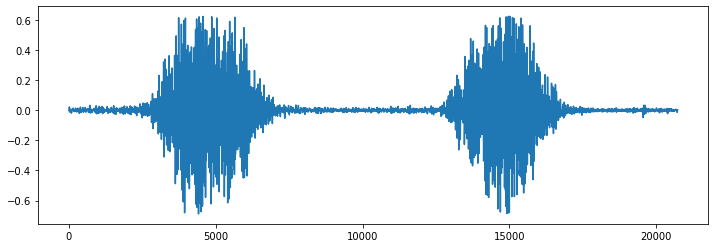

In [22]:
plt.figure(figsize=(12,4))
plt.plot(librosa_audio_data)
plt.show()

In [23]:
from IPython.display import Audio
Audio('/content/drive/MyDrive/GlobalAIHub/test1.wav')

In [24]:
mfccs=librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)

In [25]:
mfccs.shape

(40, 41)

In [26]:
mfccs

array([[-3.97981903e+02, -3.83955170e+02, -3.72321136e+02, ...,
        -3.53122101e+02, -3.47956451e+02, -3.56239349e+02],
       [ 1.36229523e+02,  1.30836609e+02,  1.25026215e+02, ...,
         1.05519821e+02,  1.00673203e+02,  8.85012207e+01],
       [ 4.36372147e+01,  4.04937553e+01,  4.01731110e+01, ...,
         2.34968510e+01,  1.60460739e+01,  7.47489071e+00],
       ...,
       [-3.40528989e+00, -5.94265985e+00, -6.29164457e+00, ...,
        -1.35020113e+00,  8.95559788e-03,  2.86863238e-01],
       [ 1.35716343e+00,  8.85644317e-01, -3.55015469e+00, ...,
        -3.22160625e+00, -5.67251778e+00, -3.12888288e+00],
       [-6.46712780e-02,  5.78054309e-01, -3.87448609e-01, ...,
         2.18127203e+00,  1.72728741e+00, -1.15266216e+00]], dtype=float32)

In [27]:
audio_dataset_path='/content/drive/MyDrive/GlobalAIHub/UrbanSound8K/audio'
metadata=pd.read_csv('/content/drive/MyDrive/GlobalAIHub/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [28]:
#dataset balancing check
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [29]:
#extracting mfcc's for every audio file
def features_extractor(file_name):
  audio,sample_rate = librosa.load(file_name, res_type='kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  
  return mfccs_scaled_features

In [31]:
extracted_features = []
for index_num,row in tqdm(metadata.iterrows()):
  file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
  final_class_labels=row["class"]
  data=features_extractor(file_name)
  extracted_features.append([data,final_class_labels])

3555it [39:08,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
8326it [1:39:27,  1.30it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
8329it [1:39:29,  1.51it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
8732it [1:44:34,  1.39it/s]


In [34]:
#Converting extracted_features to pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

feature             class
0  [-214.95764, 70.502464, -130.70279, -53.116936...          dog_bark
1  [-423.7311, 109.2299, -52.872597, 60.827538, 0...  children_playing
2  [-458.52844, 121.35432, -46.535675, 51.969467,...  children_playing
3  [-413.63254, 101.61351, -35.43868, 53.047146, ...  children_playing
4  [-446.38693, 113.68634, -52.4572, 60.349724, 2...  children_playing

In [35]:
#dataframe saving
extracted_features_df.to_csv("UrbanSound8K_df.csv")

In [36]:
#dataframe downloading
from google.colab import files
files.download("UrbanSound8K_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data Splitting and encoding

In [37]:
#Data Splitting
x=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [38]:
x.shape

(8732, 40)

In [39]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [40]:
#Label Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [41]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [42]:
#training testing sets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [43]:
x_train

array([[-1.3082390e+02,  1.1256225e+02, -2.2600878e+01, ...,
         3.2528090e+00, -1.3692100e+00,  2.7386472e+00],
       [-1.3446434e+01,  9.1048195e+01, -7.8661475e+00, ...,
        -3.2665925e+00, -5.2884049e+00, -1.5532947e+00],
       [-4.9575279e+01,  2.3543632e-01, -2.0504959e+01, ...,
         2.8775635e+00, -1.5828822e+00,  3.5109408e+00],
       ...,
       [-4.2677444e+02,  9.2583252e+01,  3.3174915e+00, ...,
         7.9330575e-01,  7.1890563e-01,  7.1397936e-01],
       [-1.4541722e+02,  1.3619025e+02, -3.3450352e+01, ...,
         1.4591718e+00, -1.9928970e+00, -8.9318532e-01],
       [-4.2099823e+02,  2.1074756e+02,  3.5814040e+00, ...,
        -5.4054899e+00, -3.3959770e+00, -1.5590971e+00]], dtype=float32)

In [50]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [45]:
x_train.shape

(6985, 40)

In [46]:
x_test.shape

(1747, 40)

In [47]:
y_train.shape

(6985, 10)

In [48]:
y_test.shape

(1747, 10)

In [49]:
#Converting extracted_features to pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

feature             class
0  [-214.95764, 70.502464, -130.70279, -53.116936...          dog_bark
1  [-423.7311, 109.2299, -52.872597, 60.827538, 0...  children_playing
2  [-458.52844, 121.35432, -46.535675, 51.969467,...  children_playing
3  [-413.63254, 101.61351, -35.43868, 53.047146, ...  children_playing
4  [-446.38693, 113.68634, -52.4572, 60.349724, 2...  children_playing

Model Oluşturma

In [51]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import metrics

In [53]:
#No one classes
num_labels=y.shape[1]
print(num_labels)

10


In [54]:
model=Sequential()
#an input layer, two hidden layer, an output layer
#first layer
model.add(Dense(1600,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#second layer
model.add(Dense(800))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#third layer
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              65600     
                                                                 
 activation (Activation)     (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0         
                                                                 
 dense_1 (Dense)             (None, 800)               1280800   
                                                                 
 activation_1 (Activation)   (None, 800)               0         
                                                                 
 dropout_1 (Dropout)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 400)               3

In [56]:
model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer="adam")

In [57]:
#Model training
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [58]:
num_epochs=100
num_batch_size=128

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.h5',verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ",duration)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 5.9239 - accuracy: 0.1944
Epoch 1: val_loss improved from inf to 1.95554, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 4s 51ms/step - loss: 5.9239 - accuracy: 0.1944 - val_loss: 1.9555 - val_accuracy: 0.3377
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 2.0797 - accuracy: 0.2817
Epoch 2: val_loss improved from 1.95554 to 1.90009, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 3s 47ms/step - loss: 2.0797 - accuracy: 0.2817 - val_loss: 1.9001 - val_accuracy: 0.3995
Epoch 3/100
54/55 [============================>.] - ETA: 0s - loss: 1.9175 - accuracy: 0.3213
Epoch 3: val_loss improved from 1.90009 to 1.75181, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 3s 46ms/step - loss: 1.9150 - accuracy: 0.3224 - val_loss: 1.7518 - val_accuracy: 0.4242
Epoch 4/100
55

In [59]:
test_accuracy=model.evaluate(x_test,y_test,verbose=0)
print(test_accuracy[1])

0.9227246642112732


***Modeli rastgele ses verileriyle test ediyoruz***

test1

In [60]:
filename="/content/drive/MyDrive/GlobalAIHub/Dog-Bark.wav"
audio, sample_rate = librosa.load(filename, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [61]:
mfccs_scaled_features.shape

(40,)

In [62]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print("Predicted Label: ",predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class[0]

(1, 40)
Predicted Label:  [3]


'dog_bark'

In [63]:
from IPython.display import Audio

In [64]:
Audio(filename)

test2

In [65]:
filename1="/content/drive/MyDrive/GlobalAIHub/test1.wav"
audio, sample_rate = librosa.load(filename1, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [66]:
mfccs_scaled_features.shape

(40,)

In [67]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print("Predicted Label: ",predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class[0]

(1, 40)
Predicted Label:  [3]


'dog_bark'

In [68]:
Audio(filename1)

test3

In [69]:
filename2="/content/drive/MyDrive/GlobalAIHub/test2.wav"
audio, sample_rate = librosa.load(filename2, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [70]:
mfccs_scaled_features.shape

(40,)

In [71]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print("Predicted Label: ",predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class[0]

(1, 40)
Predicted Label:  [8]


'siren'

In [72]:
Audio(filename2)

test4

In [73]:
filename3="/content/drive/MyDrive/GlobalAIHub/test3.wav"
audio, sample_rate = librosa.load(filename3, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [74]:
mfccs_scaled_features.shape

(40,)

In [75]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print("Predicted Label: ",predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class[0]

(1, 40)
Predicted Label:  [8]


'siren'

In [76]:
Audio(filename3)

test5

In [77]:
filename4="/content/drive/MyDrive/GlobalAIHub/test4.wav"
audio, sample_rate = librosa.load(filename4, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [78]:
mfccs_scaled_features.shape

(40,)

In [79]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print("Predicted Label: ",predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class[0]

(1, 40)
Predicted Label:  [7]


'jackhammer'

In [80]:
Audio(filename4)

test6

In [81]:
filename5="/content/drive/MyDrive/GlobalAIHub/test5.wav"
audio, sample_rate = librosa.load(filename5, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [82]:
mfccs_scaled_features.shape

(40,)

In [83]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print("Predicted Label: ",predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class[0]

(1, 40)
Predicted Label:  [8]


'siren'

In [84]:
Audio(filename5)

In [85]:
filename6="/content/drive/MyDrive/GlobalAIHub/test6.wav"
audio, sample_rate = librosa.load(filename6, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [86]:
mfccs_scaled_features.shape

(40,)

In [87]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print("Predicted Label: ",predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class[0]

(1, 40)
Predicted Label:  [7]


'jackhammer'

In [88]:
Audio(filename6)

In [89]:
filename7="/content/drive/MyDrive/GlobalAIHub/test7.wav"
audio, sample_rate = librosa.load(filename7, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [90]:
mfccs_scaled_features.shape

(40,)

In [91]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print("Predicted Label: ",predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class[0]

(1, 40)
Predicted Label:  [1]


'car_horn'

In [93]:
Audio(filename7)

In [94]:
filename8="/content/drive/MyDrive/GlobalAIHub/test8.wav"
audio, sample_rate = librosa.load(filename8, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [95]:
mfccs_scaled_features.shape

(40,)

In [96]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print("Predicted Label: ",predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class[0]

(1, 40)
Predicted Label:  [7]


'jackhammer'

In [97]:
Audio(filename8)